In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_gupta_corrections2")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from collections import defaultdict

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx
import tensorflow_probability as tfp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from lib.simdata_i3 import I3SimHandler
from lib.gupta_network_eqx import get_network_eval_v_fn
from lib.geo import cherenkov_cylinder_coordinates_w_rho_v
from lib.geo import get_xyz_from_zenith_azimuth
from lib.geo import impact_angle_cos_eta_v
from lib.gupta import c_multi_gupta_mpe_prob_midpoint2 as c_multi_gamma_mpe_prob_midpoint2
from lib.gupta import c_multi_gupta_spe_prob
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

In [2]:
dtype = jnp.float64
#eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/github/data/gupta/n96_w_penalty_1.e-3/new_model_no_penalties_tree_start_epoch_260.eqx', dtype=dtype, n_hidden=96)
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/photondata/gupta/naive/no_penalty_softplus_large/cache/new_model_no_penalties_tree_start_epoch_350.eqx', dtype=dtype, n_hidden=96)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype, gupta=True)

In [3]:
event_id = '20027'

In [4]:
bp = '/home/storage2/hans/i3files/alerts/bfrv2_no_hole_ice_flat/ftr/fudged_mcpe/'
#bp = '/home/storage2/hans/i3files/alerts/bfrv2_no_hole_ice_flat/ftr/charge/calibrated'
sim_handler = I3SimHandler(os.path.join(bp, f'meta_ds_event_{event_id}_N100_from_0_to_10_1st_pulse.ftr'),
                            os.path.join(bp, f'pulses_ds_event_{event_id}_N100_from_0_to_10_1st_pulse.ftr'),
                            '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

In [5]:
    i = 0
    meta, pulses = sim_handler.get_event_data(i)
    event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)
    #sim_handler.replace_early_pulse(event_data, pulses)

    track_time = meta['muon_time']
    track_pos = [meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']]
    track_dir = [meta['muon_zenith'], meta['muon_azimuth']]
    
    idx = event_data['charge'] > 10.0

    dom_pos = jnp.array(event_data[idx][['x', 'y', 'z']].values)
    track_pos = jnp.array(track_pos)
    track_dir = jnp.array(track_dir)
    track_dir_xyz = get_xyz_from_zenith_azimuth(track_dir)
    geo_time, closest_approach_dist, closest_approach_z, closest_approach_rho = \
                    cherenkov_cylinder_coordinates_w_rho_v(dom_pos,
                                                 track_pos,
                                                 track_dir_xyz)
   
    ix = np.argmin(closest_approach_dist)
    print(ix, closest_approach_dist[ix])

22 26.57595472759573


In [6]:
close_times = []
geo_times = []
track_times = []
charges = []
sensor = []
for i in range(100):
    meta, pulses = sim_handler.get_event_data(i)
    event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)
    #sim_handler.replace_early_pulse(event_data, pulses)

    track_time = meta['muon_time']
    track_pos = [meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']]
    track_dir = [meta['muon_zenith'], meta['muon_azimuth']]

    dom_pos = jnp.array(event_data[['x', 'y', 'z']].values)
    track_pos = jnp.array(track_pos)
    track_dir = jnp.array(track_dir)
    track_dir_xyz = get_xyz_from_zenith_azimuth(track_dir)
    geo_time, closest_approach_dist, closest_approach_z, closest_approach_rho = \
                    cherenkov_cylinder_coordinates_w_rho_v(dom_pos,
                                                 track_pos,
                                                 track_dir_xyz)

    closest_approach_dist = np.array(closest_approach_dist)
    geo_time = np.array(geo_time)
    ix = np.abs(closest_approach_dist.flatten() - 14.8) < 0.2
    if np.sum(ix) > 0:
        close_times.append(event_data['time'].values.flatten()[ix])
        geo_times.append(geo_time.flatten()[ix])
        track_times.append(track_time)
        charges.append(event_data['charge'].values.flatten()[ix])
        sensor.append(event_data['sensor_id'].values.flatten()[ix])

In [7]:
print(charges)

[array([928.20422096]), array([916.99231173]), array([954.33590291]), array([882.67978402]), array([925.85001964]), array([963.48787591]), array([967.69601228]), array([940.41667112]), array([914.84410347]), array([858.08429209]), array([82.30293388]), array([84.42858225]), array([833.91740015]), array([862.58074831]), array([922.28927806]), array([975.37660229]), array([957.4552143]), array([955.13044392]), array([903.92647258]), array([957.45520915]), array([916.31547958]), array([1010.33655087]), array([905.07415223]), array([873.88093988]), array([929.20475241]), array([934.03087186])]


In [8]:
f, r = divmod(sensor[0], 60)
print('string:', f+1, 'dom', r+1)

string: [66] dom [20]


In [9]:
print(np.sort(np.array(close_times).flatten()-np.array(track_times)))
print(np.sort(np.array(geo_times).flatten()))

[ 6427.21500691  9170.56435231  9178.11010011  9182.70607388
  9194.68371509  9196.93109684  9202.64200855  9203.13258173
  9208.18096108  9210.71742846  9213.99571678  9220.6261072
  9221.3212881   9226.74922904  9227.22409271  9229.34592036
  9230.25475355  9230.35636643  9234.28692593  9243.77125092
  9257.50484818  9259.77064743  9264.36875074  9267.97328702
  9953.74687508 11998.69440768]
[9213.9283786 9213.9283786 9213.9283786 9213.9283786 9213.9283786
 9213.9283786 9213.9283786 9213.9283786 9213.9283786 9213.9283786
 9213.9283786 9213.9283786 9213.9283786 9213.9283786 9213.9283786
 9213.9283786 9213.9283786 9213.9283786 9213.9283786 9213.9283786
 9213.9283786 9213.9283786 9213.9283786 9213.9283786 9213.9283786
 9213.9283786]


(-25.0, 20.0)

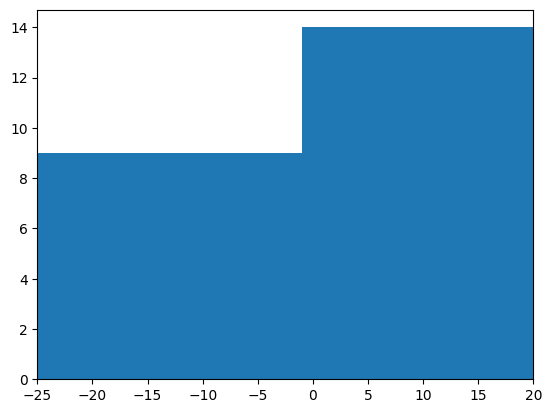

In [10]:
plt.hist(np.array(close_times).flatten()-np.array(track_times)-np.array(geo_times).flatten())
plt.xlim([-25, 20])

In [11]:
min_times = []
for i in range(100):
    meta, pulses = sim_handler.get_event_data(i)
    event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)
    sim_handler.replace_early_pulse(event_data, pulses)

    track_time = meta['muon_time']
    track_pos = [meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']]
    track_dir = [meta['muon_zenith'], meta['muon_azimuth']]
    
    idx = event_data['charge'] > 10.0

    dom_pos = jnp.array(event_data[idx][['x', 'y', 'z']].values)
    track_pos = jnp.array(track_pos)
    track_dir = jnp.array(track_dir)
    track_dir_xyz = get_xyz_from_zenith_azimuth(track_dir)
    geo_time, closest_approach_dist, closest_approach_z, closest_approach_rho = \
                    cherenkov_cylinder_coordinates_w_rho_v(dom_pos,
                                                 track_pos,
                                                 track_dir_xyz)

    min_times.append(np.min(event_data[idx]['time']-track_time-geo_time))

In [12]:
print(np.sort(np.array(min_times).flatten()))

[-2.78884224e+03 -6.15740108e+02 -4.06123342e+02 -3.61062017e+02
 -7.24195382e+01 -7.04883688e+01 -6.67164947e+01 -5.34681600e+01
 -5.00412987e+01 -4.48806779e+01 -4.46100695e+01 -4.33640263e+01
 -4.30089771e+01 -3.98208333e+01 -3.95961201e+01 -3.94131633e+01
 -3.73506645e+01 -3.72342175e+01 -3.64497614e+01 -3.60176256e+01
 -3.58480982e+01 -2.88758427e+01 -2.84841601e+01 -2.84341682e+01
 -2.80529261e+01 -2.37646729e+01 -2.18025988e+01 -2.15780755e+01
 -1.93402016e+01 -1.74647047e+01 -1.69972818e+01 -1.61019475e+01
 -1.59261851e+01 -1.38536303e+01 -1.30860182e+01 -1.24648580e+01
 -1.14754466e+01 -1.13431155e+01 -1.12863700e+01 -1.08604427e+01
 -1.04739852e+01 -9.00359756e+00 -5.74741751e+00 -4.97960566e+00
 -2.99943236e+00 -1.96470694e+00 -1.14662796e+00 -1.00217609e+00
 -4.79456329e-01 -3.97584576e-01  5.84012790e-01  1.29268255e+00
  3.46152317e+00  3.75736415e+00  6.17358815e+00  6.99010674e+00
  9.78745688e+00  1.11930815e+01  1.16598683e+01  1.16814443e+01
  1.23447994e+01  1.32957

In [13]:
meta_muon['time']

NameError: name 'meta_muon' is not defined

In [18]:
from icecube import dataio, dataclasses, simclasses, icetray

In [15]:
f = dataio.I3File('/home/storage2/hans/i3files/alerts/bfrv2_no_hole_ice_flat/i3_nominal/event_20027_N100_Part02.i3.zst')

In [16]:
frame = f.pop_physics()

In [17]:
pulses = dataclasses.I3RecoPulseSeriesMap.from_frame(frame, 'TWSRTHVInIcePulsesIC')
mcpe_map = frame['I3MCPESeriesMapWithoutNoise']

In [21]:
key = icetray.OMKey(66, 20, 0)

In [22]:
pulses_close = pulses[key]
mcpe_close = mcpe_map[key]

In [25]:
print(sum([q.charge for q in pulses_close]))
print(sum([q.npe * 0.85 / 1.27 for q in mcpe_close]))

768.899998664856
953.7401574803013


In [29]:
print(pulses_close[0].time)
print(mcpe_close[0].time)

10057.0
10056.156227644758


In [31]:
dataclasses.get_most_energetic_muon(frame['I3MCTree'])

In [34]:
f = dataio.I3File('/home/storage2/hans/i3files/alerts/bfrv2_no_hole_ice_flat/i3_nominal/event_20027_N100_Part00.i3.zst')
while f.more():
    frame = f.pop_physics()
    pulses = dataclasses.I3RecoPulseSeriesMap.from_frame(frame, 'TWSRTHVInIcePulsesIC')
    mcpe_map = frame['I3MCPESeriesMapWithoutNoise']
    key = icetray.OMKey(66, 20, 0)
    pulses_close = pulses[key]
    mcpe_close = mcpe_map[key]
    muon_time = dataclasses.get_most_energetic_muon(frame['I3MCTree']).time
    
    print(sum([q.charge for q in pulses_close])/0.85, pulses_close[0].time-muon_time, mcpe_close[0].time-muon_time)
    
    
    

927.7058843304129 9215.891936378524 9215.526144753703
916.4999945724712 9212.132907217036 9215.6096731428
953.8235366344452 9214.740610448747 9215.060233167796
882.2058886640212 9221.620545176256 9216.279007554422
925.3529469405904 9216.356675312752 9215.577356082524
962.9705960960949 9188.54613144804 9215.375252366433
967.1764731933089 9202.43004486837 9214.879753709207
939.9117778329288 9218.028082252114 9214.552451185375
914.3529396547991 9217.25381901583 9216.635428200969
939.8823484953713 9215.971637138518 9215.727912000804
